In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
alphas = []
t=1
while(1/t>0.01):
    alphas.append(featurize_x_train.shape[0]*1/t)
    t=t+1
alphas = alphas

NameError: name 'featurize_x_train' is not defined

In [ ]:
alphas2 = np.unique(np.concatenate((10.**np.arange(-3,1,1),np.arange(1,2,.3))))

GRID SEARCH FUNCTION FOR RIDGE, WE MULTIPLY THE LAMBDAS WITH TOTAL DATA SIZE SINCE IT TAKES TRUE SQUARED ERROR AS ITS LOSS FUNCTION(SKLEARN)

In [7]:
def do_grid_search_ridge(X_train, y_train, X_val, y_val):

	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	param_grid = [{'alpha':alphas }]

	ridge_regression_estimator = Ridge()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_alpha", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_alpha"])
	return grid, df_toshow

In [8]:
grid,results = do_grid_search_ridge(featurize_x_train,y_train,featurize_x_test,y_test)

In [9]:
def ridge_regression(X,y,l2_reg):
    n = X.shape[0]
    sklearn_ridge = Ridge(alpha=l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X, y)
    sklearn_ridge_coefs = sklearn_ridge.coef_
    return sklearn_ridge_coefs

        lambda     Error
0   100.000000  0.171068
1    50.000000  0.157508
2    33.333333  0.153081
3    25.000000  0.150676
4    20.000000  0.149038
..         ...       ...
94    1.052632  0.141597
95    1.041667  0.141655
96    1.030928  0.141713
97    1.020408  0.141772
98    1.010101  0.141830

[99 rows x 2 columns]


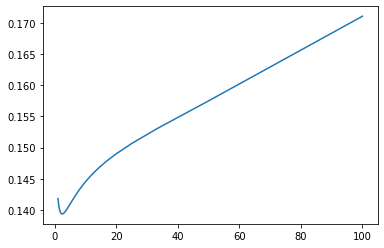

In [49]:
m1=[]
df = pd.DataFrame(columns=['lambda','Error'])
for t in alphas:
    w=ridge_regression(featurize_x_train,y_train,t)
    t_reg,c,f = get_target_and_featurizer(coefs_true=w)
    m=mean_squared_error(np.dot(f(x_test),w),y_test)
    m1.append(m)
    df = df.append({'lambda':t,'Error':m},ignore_index=True)
print(df)
plt.plot(alphas,m1)
plt.show()

The table abpve also contains the value of lambda returned by Grid search

Minimum error occurs at below value of lambda

In [50]:
print(grid.best_params_['alpha'])

2.380952380952381


VISUALIZING PREDICTION FUNCTIONS

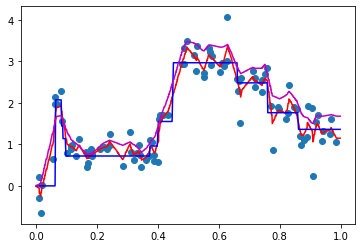

In [71]:
coeffs_ridge=ridge_regression(featurize_x_train,y_train,grid.best_params_['alpha'])
clf = SGDRegressor(max_iter=1000,penalty=None)
coeff_linear=clf.fit(featurize_x_train,y_train).coef_
fig, ax = plt.subplots()
plt.scatter(x_train,y_train)
t_reg,c,f_ridge = get_target_and_featurizer(coefs_true=coeffs_ridge)
t_grad,c1,f1 = get_target_and_featurizer(coefs_true=coeff_linear)
x_test1 = np.sort(x_test)
x_1 = f(x_test1)
x_2 = featurize(x_test1)
x_3 = f1(x_test1)
ax.plot(x_test1, np.dot(x_1,c), 'r',label="Ridge")
ax.plot(x_test1, np.dot(x_2,coefs_true), 'b',label="Target Function")
ax.plot(x_test1, np.dot(x_3,coeff_linear), 'm',label="Linear Function")
plt.show()

RED - RIDGE TARGET FUNCTION
BLUE - TARGET FUNCTION
MAGENTA - UNREGULARIZED SQUARED FIT

In [13]:
def compare_parameter_vectors(pred_fns):
	# Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
	# "coefs" key
	fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals)
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.3)
	fig.show()

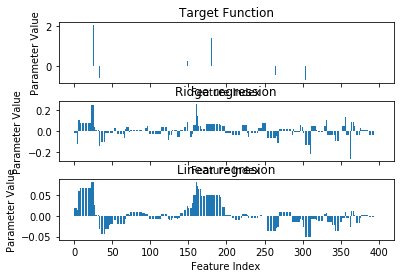

In [14]:
pred_fns=[]
#x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
pred_fns.append({"name":"Target Function","coefs":coefs_true, "preds": y_test })
pred_fns.append({"name":"Ridge regression","coefs":c, "preds": x_1@c })
pred_fns.append({"name":"Linear regresion","coefs":coeff_linear, "preds":np.dot(x_3,coeff_linear)})

compare_parameter_vectors(pred_fns)


As we can see from the diagragm above, we can see that the features in the target function which are not 0, are almost similar to that of ridge regression. Although ridge regression does not provide sparse values, it does provide close to sparse values 
Other features are distributed in such way such that their summation would lead to a small variance from the target function
Linear regression does not provide sparse values for any coefficient

In [15]:
pred_regression = coeffs_ridge
print(pred_regression.shape)
print("Maximum coefficient value is : " + str(np.max(pred_regression)) +"and the coefficient is : "+ str(np.argmax(pred_regression)))

(400,)
Maximum coefficient value is : 0.26180533102645787and the coefficient is : 161


For ridge regression coefficients lie between -0.2 to 0.2

CONFUSION MATRIX

In [55]:
epsilon = [1e-0,1e-1,1e-3,1e-6]
for eps in epsilon:
    w_pred=np.array(coeffs_ridge)
    w_true=np.array(coefs_true)
    w_pred[abs(coeffs_ridge)<eps]=0
    #Assuming 1 is the non zero class for both actual and predicted coeffs
    w_pred[abs(coeffs_ridge)>eps]=1
    w_true[w_true!=0]=1
    print(confusion_matrix(w_pred,w_true))


[[390  10]
 [  0   0]]
[[365   5]
 [ 25   5]]
[[ 11   0]
 [379  10]]
[[  5   0]
 [385  10]]


Experiments with shooting algorithm

In [60]:
def soft(a,delta):
    sign_a = np.sign(a)
    if np.abs(a)-delta <0:
        return 0 
    else:
        return sign_a*(abs(a)-delta)
        
def lasso_regression(X,y,alpha,cyclic=True,is_w_zero=False,w=None):
    if w is None:
        t1 = inv(np.dot(X.T,X)+alpha*np.identity(X.shape[1]))
        t2 = np.dot(t1,X.T)
        if not is_w_zero:
            w = np.dot(t2,y)
        else:
            w=np.zeros(X.shape[1])
    #print(mean_squared_error(np.dot(X,w),y))
    iter=0
    while(X.shape[0]*mean_squared_error(np.dot(X,w),y)>10**-8 and iter<1000):

        for j in range(0,X.shape[1]):
            if not cyclic:
                index = np.random.randint(X.shape[1])
            else:
                index = j
            xj = X[:,index].reshape(-1,1)
            wj = w[index]
            aj = 2*xj.T@xj
            cj = 2*np.dot(xj.T,(y-np.dot(X,w)).reshape(-1,1)+wj*xj)
            if(aj==0): 
                w[index]=0
                continue
            w[index] = soft(cj/aj,alpha/aj)
        iter=iter+1
    return w

In [61]:
def do_grid_search_lasso(X_train, y_train, X_val, y_val):

	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	param_grid = [{'alpha':alphas2 }]

	lasso_regression_estimator = Lasso()
	grid = GridSearchCV(estimator=lasso_regression_estimator,
						param_grid=param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_alpha", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_alpha"])
	return grid, df_toshow

In [62]:
grid_lasso,result_lasso=do_grid_search_lasso(featurize_x_train,y_train,featurize_x_test,y_test)
print(grid_lasso.best_params_['alpha']*featurize_x_train.shape[0])

1.0


In [64]:
e1=[]
e2=[]
e3=[]
e4=[]
for t in alphas2:
    cyclic_zero_coeffs = lasso_regression(featurize_x_train,y_train,t,cyclic=True,is_w_zero=True)
    cyclic_coeffs_murphy = lasso_regression(featurize_x_train,y_train,t,cyclic=True,is_w_zero=False)
    random_zero_coeffs = lasso_regression(featurize_x_train,y_train,t,cyclic=False,is_w_zero=True)
    random_coeffs = lasso_regression(featurize_x_train,y_train,t,cyclic=False,is_w_zero=False)
    t1,c1,f1 = get_target_and_featurizer(coefs_true=cyclic_zero_coeffs)
    t2,c2,f2 = get_target_and_featurizer(coefs_true=cyclic_coeffs_murphy)
    t3,c3,f3 = get_target_and_featurizer(coefs_true=random_zero_coeffs)
    t4,c4,f4 = get_target_and_featurizer(coefs_true=random_coeffs)
    pred1= f1(x_test)@c1
    pred2= f2(x_test)@c2
    pred3= f3(x_test)@c3
    pred4= f4(x_test)@c4
    e1.append(mean_squared_error(pred1,y_test))
    e2.append(mean_squared_error(pred2,y_test))
    e3.append(mean_squared_error(pred3,y_test))
    e4.append(mean_squared_error(pred4,y_test))

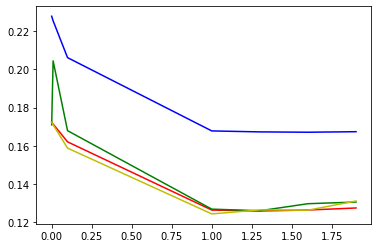

In [65]:
plt.plot(alphas2,e1,color='b')
plt.plot(alphas2,e2,color='r')
plt.plot(alphas2,e3,color='g')
plt.plot(alphas2,e4,color='y')
plt.show()


The above values for lambda contains the value returned from grid search

BLUE - CYCLIC AND ZERO WEIGHT CONFIG
RED - CYCLIC AND MURPHY CONFIG
GREEN - RANDOM AND ZERO WEIGHT CONFIG
YELLOW - RANDOM AND MURPHY

   lambda     Error
0   0.001  0.172427
1   0.010  0.170916
2   0.100  0.158882
3   1.000  0.125317
4   1.300  0.124191
5   1.600  0.127403
6   1.900  0.128273


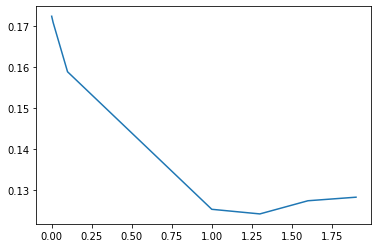

In [66]:
m1=[]
df = pd.DataFrame(columns=['lambda','Error'])
for t in alphas2:
    w=lasso_regression(featurize_x_train,y_train,t,cyclic=False,is_w_zero=False)
    t1,c1,f1 = get_target_and_featurizer(coefs_true=w)
    m=mean_squared_error(np.dot(f1(x_test),w),y_test)
    m1.append(m)
    df = df.append({'lambda':t,'Error':m},ignore_index=True)
print(df)
plt.plot(alphas2,m1)
plt.show()

In [67]:
print("Min error at ")
print(df.loc[df['Error']==df['Error'].min()]['lambda'])

Min error at 
4    1.3
Name: lambda, dtype: float64


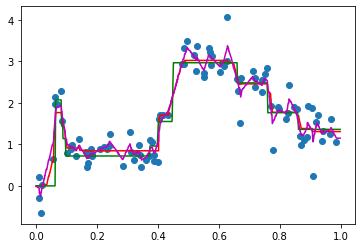

In [68]:
coeffs_lasso=lasso_regression(featurize_x_train,y_train,1.3)
fig, ax = plt.subplots()
plt.scatter(x_train,y_train)
t_lasso,c,f = get_target_and_featurizer(coefs_true=coeffs_lasso)
x_test1 = np.sort(x_test)
ax.plot(x_test1, t_lasso(x_test1), 'r')
ax.plot(x_test1, target_fn(x_test1), 'g')
ax.plot(x_test1, t_reg(x_test1), 'm')

RED - LASSO TARGET FUNCTION
BLUE - TARGET FUNCTION
MAGENTA - RIDGE SQUARED FIT

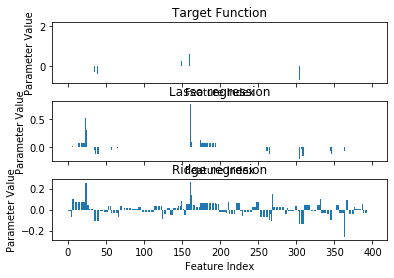

In [70]:
pred_fns=[]
pred_fns.append({"name":"Target Function","coefs":coefs_true, "preds": y_test })
pred_fns.append({"name":"Lasso regression","coefs":c, "preds": featurize_x_test@c })
pred_fns.append({"name":"Ridge regresion","coefs":coeffs_ridge, "preds":np.dot(featurize_x_test,coeffs_ridge)})

compare_parameter_vectors(pred_fns)


We can see that Lasso regression introduces sparsity and that it gives correct zero values for many features having zero values by the target function. Ridge regression attempts to bring the coeffs close to zero but not zero. As a result the error result given by lasso regression is an improvement over ridge

The mean squared error with the model of lambda = 1.3 and lasso regression is

In [109]:
print(mean_squared_error(f(x_test)@c,y_test))

0.12595145200788974


The error for ridge regresion is greater and that is why Lasso regression is a better regression technique

In [73]:
print("Ridge regression error is")
print(mean_squared_error(f_ridge(x_test)@coeffs_ridge,y_test))

Ridge regression error is
0.1393748589134217


HOMOTOPY METHOD

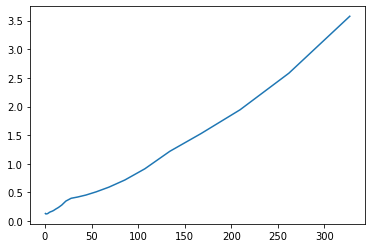

In [74]:
lambda_max = max(2*np.abs(featurize_x_train.T.dot(y_train)))
lambdas =lambda_max*0.8**np.arange(0,30,1)
w=np.zeros(featurize_x_train.shape[1])
e=[]
for step in lambdas:
    coeffs_warm = lasso_regression(featurize_x_train,y_train,step,cyclic=False,is_w_zero=False,w=w)
    w = coeffs_warm
    tw,cw,fw=get_target_and_featurizer(coefs_true=coeffs_warm)
    e.append(mean_squared_error(fw(x_test)@coeffs_warm,y_test))
plt.plot(lambdas,e)

Therefore we can see that the lambda max which started from a value close to 300 and gave a higher error eventually reduces to close to zero as the lambda decreases due to warm coeffs algorithm

Making data 0 centered

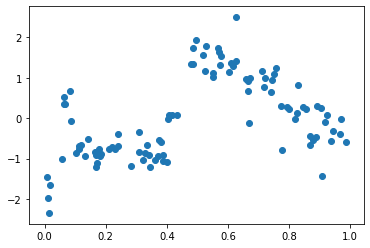

In [75]:
XX = np.zeros((100,2))
XX[:,0]=x_train
XX[:,1]=y_train
scaler = preprocessing.StandardScaler().fit(XX)
XX=scaler.transform(XX)
YY = np.zeros((x_test.shape[0],2))
YY[:,0]=x_test
YY[:,1]=y_test
YY=scaler.transform(YY)
x_test_m = YY[:,0]
y_test_m=YY[:,1]
x_train_m = XX[:,0]
y_train_m=XX[:,1]
plt.scatter(x_train,y_train_m)
plt.show()


        lambda     Error
0   100.000000  0.285615
1    50.000000  0.249222
2    33.333333  0.229412
3    25.000000  0.215896
4    20.000000  0.205932
..         ...       ...
94    1.052632  0.157990
95    1.041667  0.158045
96    1.030928  0.158101
97    1.020408  0.158157
98    1.010101  0.158214

[99 rows x 2 columns]


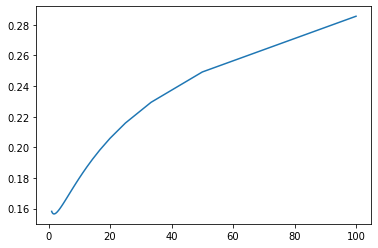

In [76]:
m1=[]
df = pd.DataFrame(columns=['lambda','Error'])
for t in alphas:
    w=ridge_regression(featurize_x_train,y_train_m,t)
    t1,c1,f1 = get_target_and_featurizer(coefs_true=w)
    m=mean_squared_error(np.dot(f1(x_test),w),y_test_m)
    m1.append(m)
    df = df.append({'lambda':t,'Error':m},ignore_index=True)
print(df)
plt.plot(alphas,m1)
plt.show()

In [77]:
print("Min error at ")
print(df.loc[df['Error']==df['Error'].min()]['lambda'])

Min error at 
55    1.785714
Name: lambda, dtype: float64


   lambda     Error
0   0.001  0.190452
1   0.010  0.189025
2   0.100  0.176527
3   1.000  0.140803
4   1.300  0.144398
5   1.600  0.141324
6   1.900  0.145115


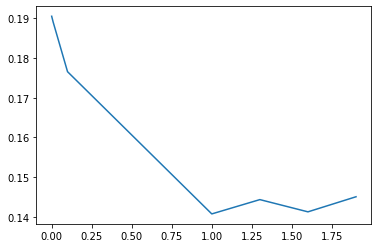

In [78]:
m1=[]
df = pd.DataFrame(columns=['lambda','Error'])
for t in alphas2:
    w=lasso_regression(featurize_x_train,y_train_m,t,cyclic=False,is_w_zero=False)
    t1,c1,f1 = get_target_and_featurizer(coefs_true=w)
    m=mean_squared_error(np.dot(f1(x_test),w),y_test_m)
    m1.append(m)
    df = df.append({'lambda':t,'Error':m},ignore_index=True)
print(df)
plt.plot(alphas2,m1)
plt.show()

In [79]:
print("Min error at ")
print(df.loc[df['Error']==df['Error'].min()]['lambda'])

Min error at 
3    1.0
Name: lambda, dtype: float64


From the graphs plotted we can see that the value of lambda that is the penalization factor has decreased for ridge regression as well as for lasso regression

In [80]:
lambda_max_initial = max(2*np.abs(featurize_x_train.T.dot(y_train)))
lambda_max_after = max(2*np.abs(featurize_x_train.T.dot(y_train_m)))
print("We can also see that the value of lambda max decreased from "+str(lambda_max_initial)+" to "+str(lambda_max_after)+" after 0 centering y")

We can also see that the value of lambda max decreased from 327.28283232952117 to 68.48117686312149 after 0 centering y


PROJECTED SGD via VARIABLE SPLITTING

In [81]:
def projected_stochastic_grad_descent(X, y, lambdas,alpha=0.01,num_epoch=100):
    t1 = inv(np.dot(X.T,X)+alpha*np.identity(X.shape[1]))
    t2 = np.dot(t1,X.T)
    w = np.dot(t2,y)
    num_instances, num_features = X.shape[0], X.shape[1]
    t=1
    for j in range(0,num_epoch):
        for i in range(0,num_instances):            
            w_pos = np.where(w>0,w,0).reshape(-1,1)
            w_neg = np.where(w<0,w,0).reshape(-1,1)
            w_neg = np.abs(w_neg)
            index = np.random.randint(num_instances)
            x = X[index:index+1,:]
            yn=y[index]
            w_pos2=np.array(w_pos)
            w_pos = w_pos - (alpha*(lambdas*np.identity(x.shape[0]).T+((np.dot(x,w) - yn)*x).T))
            w_neg = w_neg - (alpha*(lambdas*np.identity(x.shape[0]).T-((np.dot(x,w) - yn)*x).T))
            w_pos = np.where(w_pos>0,w_pos,0)
            w_neg = np.where(w_neg>0,w_neg,0)
            w = w_pos-w_neg
    return w

In [84]:
alphas3 = np.array(10.**np.arange(-6,0,1))

     lambda  Error_PSGD  Error_Lasso_shooting  Difference_in_Error
0  0.000001    0.171299              0.172590            -0.001290
1  0.000010    0.171318              0.172588            -0.001271
2  0.000100    0.171358              0.172573            -0.001215
3  0.001000    0.171449              0.172422            -0.000972
4  0.010000    0.170019              0.170972            -0.000953
5  0.100000    0.160510              0.159095             0.001415


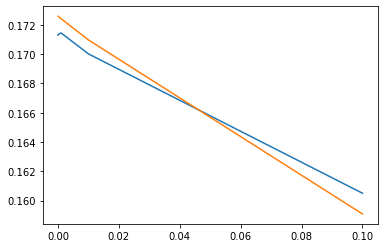

In [89]:
m1=[]
m2=[]
df = pd.DataFrame(columns=['lambda','Error_PSGD','Error_Lasso_shooting','Difference_in_Error'])
for t in alphas3:
    w=projected_stochastic_grad_descent(featurize_x_train,y_train,t,0.00001,100)
    w2=lasso_regression(featurize_x_train,y_train,t,cyclic=False,is_w_zero=False)
    t1,c1,f1 = get_target_and_featurizer(coefs_true=w)
    t2,c2,f2 = get_target_and_featurizer(coefs_true=w2)
    m=mean_squared_error(np.dot(f1(x_test),w),y_test)
    mm=mean_squared_error(np.dot(f2(x_test),w2),y_test)    
    m1.append(m)
    m2.append(mm)
    df = df.append({'lambda':t,'Error_PSGD':m,'Error_Lasso_shooting':mm,'Difference_in_Error':m-mm},ignore_index=True)
print(df)
plt.plot(alphas3,m1)
plt.plot(alphas3,m2)
plt.show()

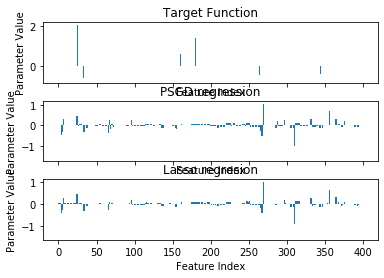

In [91]:
pred_fns=[]
#x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
pred_fns.append({"name":"Target Function","coefs":coefs_true, "preds": y_test })
pred_fns.append({"name":"PSGD regression","coefs":w[:,0], "preds":y_test })
pred_fns.append({"name":"Lasso regresion","coefs":w2, "preds":np.dot(x_3,c)})

compare_parameter_vectors(pred_fns)

PSGD Algorithm produces almost similar less sparse values than shooting algorithm